In [22]:
import pandas as pd
import numpy as np
import re

In [23]:
#read in game information
steam = pd.read_csv("./steam_all/steam_all_last_attempt.csv")

In [24]:
steam1 = steam

In [25]:
steam1.shape

(6902, 17)

In [26]:
steam1.columns

Index([u'main_link', u'no_user', u'title', u'url', u'mother_node', u'app_id',
       u'publish', u'user_rating', u'keywords', u'Rdate', u'critics_review',
       u'genre', u'list_title', u'desc', u'type', u'no_links', u'game_spcs'],
      dtype='object')

In [27]:
steam1["no_user"][0]

'\r\n\t\t\t\t\t\t\t\t\t\t\t\t- 92% of the 419 user reviews for this game are positive.\t\t\t\t\t\t\t\t\t\t\t'

In [28]:
steam1["no_user"] = steam1["no_user"].str.strip()

In [29]:
#grabbing percentage of positive reviews
steam1["percent"] = steam1["no_user"].str.extract("- (\d{2,3})\% .+")

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [30]:
steam1["percent"] = pd.to_numeric(steam1["percent"])

In [31]:
#grabbing number of reviews
steam1["reivew_users"]=pd.to_numeric(steam1["no_user"].str.extract("- \d{2,3}\% of the (.+) user .+").str.replace(",",""))

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [32]:
#construct a keyword list without extra spaces and lines
for i in range(steam1.shape[0]):
    steam1.loc[i,"keywords_list"] = ', '.join(map(lambda x: x.strip(),str(steam1["keywords"][i]).split(",")))

In [33]:
steam1["type"].value_counts()

None                    4263
Downloadable Content    2628
not_found                 11
Name: type, dtype: int64

In [34]:
#checking if original game differs from title - these should match with DLC and other type
for i in range(steam1.shape[0]):
    if steam1.loc[i,"title"] != steam1.loc[i,"mother_node"]:
        steam1.loc[i,"sub"] = 1

In [35]:
#identifying listing that are not downloadable content but has a different original game
for i in range(steam1.shape[0]):
    if (steam1.loc[i,"sub"] == 1)&(steam1.loc[i,"type"]!="Downloadable Content"):
        steam1.loc[i,"dlc_notsub"] = 1

In [36]:
#review user rating
steam1["user_rating"].value_counts()

not-found                  2913
Very Positive              1984
Mostly Positive             883
Positive                    879
Overwhelmingly Positive     243
Name: user_rating, dtype: int64

In [37]:
#assign not-found to NaN
steam1.replace("not-found",np.NaN, inplace=True)

In [38]:
#extracting genres from a list that includes both publishers and producers
for i in range(steam1.shape[0]):
    steam1.loc[i,"genre_list"] = ", ".join(list(set(str(steam1["genre"][i]).split(","))^set(str(steam1["publish"][i]).split(","))))

In [39]:
#size of the dataset
steam1.shape

(6902, 23)

In [40]:
steam1["type"].value_counts()

None                    4263
Downloadable Content    2628
not_found                 11
Name: type, dtype: int64

In [41]:
#the final dataset should only consist of original games - soundtracks and downloadable content information
# will be added to the original game
a = steam1[(steam1["type"]=="None")].groupby("mother_node").first().reset_index()

In [42]:
a.shape

(4165, 23)

In [43]:
a.rename(columns={"title":"title_steam"},inplace=True)

In [44]:
#creating a database to count the number of DLCs
downloadable = steam1.loc[steam1["type"]=="Downloadable Content"]

In [45]:
downloadable['type'].value_counts()

Downloadable Content    2628
Name: type, dtype: int64

In [46]:
downloadable.columns

Index([u'main_link', u'no_user', u'title', u'url', u'mother_node', u'app_id',
       u'publish', u'user_rating', u'keywords', u'Rdate', u'critics_review',
       u'genre', u'list_title', u'desc', u'type', u'no_links', u'game_spcs',
       u'percent', u'reivew_users', u'keywords_list', u'sub', u'dlc_notsub',
       u'genre_list'],
      dtype='object')

In [47]:
dlc_count = downloadable[["title","mother_node"]].groupby("mother_node").agg(["count"])

In [48]:
dlc_count1 = dlc_count.reset_index()

In [49]:
#making sure that there is no repating values
dlc_count1.columns = dlc_count1.columns.get_level_values(0)

In [50]:
dlc_count1.rename(columns={'title':'no_dlc'}, inplace=True)
dlc_count1.rename(columns={'mother_node':'mother_dlc'}, inplace=True)

In [51]:
dlc_count1.columns

Index([u'mother_dlc', u'no_dlc'], dtype='object')

In [52]:
dlc_count1.shape

(665, 2)

In [53]:
a.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list'],
      dtype='object')

In [54]:
#adding number of dlc in the 
games_dlc=pd.merge(a, dlc_count1, how="left", left_on = "mother_node", right_on = "mother_dlc")

In [55]:
for i in range(games_dlc.shape[0]):
    if pd.isnull(games_dlc.loc[i, "no_dlc"])==True:
        games_dlc.loc[i,"no_dlc"] = 0

In [56]:
games_dlc.loc[games_dlc["no_dlc"]>=1,"dlc_av"] = 1
games_dlc.loc[games_dlc["no_dlc"]==0,"dlc_av"] = 0

In [57]:
games_dlc["dlc_av"].value_counts()

0.0    3684
1.0     481
Name: dlc_av, dtype: int64

In [58]:
games_dlc.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av'],
      dtype='object')

In [59]:
games_dlc.shape

(4165, 26)

In [60]:
#reading in data on top seller ranking and price
steam_rank = pd.read_csv("./ranking and price/ranking_withprice.csv")

In [61]:
steam_rank.shape

(7827, 3)

In [62]:
# revmoing duplicate records - I found out that the original steam listing consisted of repeating records of the same game
# while the ranking is different, the price is the same.
steam_rank_no = steam_rank[["title","rank_no"]].sort_values(by = "rank_no").groupby(by="title").first().reset_index()

In [63]:
steam_rank_no.head(3)

,title,rank_no
0,,6413
1,- Red Obsidian Remnant,3567
2,Double Oik!,3275


In [64]:
steam_rank_no.loc[0,"title"]=""

In [65]:
steam_rank_no.shape

(7642, 2)

In [66]:
# clearning up price data
steam_rank["price"] = steam_rank["price"].str.strip()

In [67]:
for i in range(len(steam_rank)):
    if type(steam_rank.loc[i,"price"]) is str:
        if steam_rank.loc[i,"price"] == "Free":
            steam_rank.loc[i,"price"] = 0
        else:
            steam_rank.loc[i,"price"] = float(steam_rank.loc[i,"price"])
    else:
        steam_rank.loc[i,"price"] = np.NaN

In [68]:
steam_rank[["title","price"]].head(5)

,title,price
0,Prey,59.99
1,PLAYERUNKNOWN'S BATTLEGROUNDS,29.99
2,Rocket League,13.99
3,Star Wars Complete Collection,60.68
4,Sid Meiers Civilization VI,40.19


In [69]:
sum(pd.isnull(steam_rank["price"]))

0

In [70]:
steam_rank["price"]=steam_rank["price"].astype(float)

In [71]:
#removing duplicates
steam_price = steam_rank[["title","price"]].groupby("title").agg("mean")

In [72]:
steam_price = steam_price.reset_index()

In [73]:
steam_price.shape

(7642, 2)

In [74]:
#creating a df with unique price and rank
steam_price_rank = pd.merge(steam_price, steam_rank_no,how = "inner",left_on = "title", right_on= "title")

In [75]:
steam_price_rank.shape

(7641, 3)

In [76]:
# extracting game and original game relationship from the game information df
steam_name = steam1[["mother_node","title"]]

In [77]:
steam_name = steam_name.drop_duplicates()

In [78]:
steam_name.shape

(6763, 2)

In [79]:
steam_name.columns

Index([u'mother_node', u'title'], dtype='object')

In [80]:
steam_price_rank.columns

Index([u'title', u'price', u'rank_no'], dtype='object')

In [81]:
#merge rank and price with game and oritinal game mapping 
ranking = pd.merge(steam_name, steam_price_rank, how="inner",left_on="title",right_on="title")

In [82]:
ranking.shape

(6259, 4)

In [83]:
ranking = ranking.sort_values("rank_no")

In [84]:
#removing duplicate games 
ranking_mother = ranking.groupby("mother_node").first().reset_index()

In [85]:
ranking_mother.head(3)

,mother_node,title,price,rank_no
0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567
1,"""BUTTS: The VR Experience""","""BUTTS: The VR Experience""",0.99,7504
2,#Archery,#Archery,9.99,5477


In [86]:
ranking_mother.shape

(4067, 4)

In [87]:
ranking_mother.columns

Index([u'mother_node', u'title', u'price', u'rank_no'], dtype='object')

In [88]:
games_dlc.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av'],
      dtype='object')

In [89]:
ranking_mother.rename(columns={'mother_node':'mother_rank','title':'title_rank'}, inplace=True)

In [90]:
#merging information back to the unique game df
rank = pd.merge(games_dlc, ranking_mother, how = "inner", left_on = "mother_node", right_on = "mother_rank")

In [91]:
rank.shape

(3899, 30)

In [92]:
sum(pd.isnull(rank["rank_no"]))

0

In [93]:
sum(pd.isnull(rank["Rdate"]))

8

In [94]:
rank.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no'],
      dtype='object')

In [95]:
#adding information regarding current player no, and all time high
steam_player = pd.read_csv("./player_count/users1.csv")

In [96]:
steam_player.shape

(8061, 5)

In [97]:
steam_player.columns

Index([u'current', u'all_time', u'app_id', u'day', u'title'], dtype='object')

In [98]:
steam_app = steam1[["mother_node","title","app_id"]]

In [99]:
steam_app = steam_app.drop_duplicates()

In [100]:
steam_app.head(5)

,mother_node,title,app_id
0,Prey,Prey,480490
1,Tales of Berseria,Tales of Berseria,429660
2,RESIDENT EVIL 7 biohazard / BIOHAZARD 7 reside...,RESIDENT EVIL 7 biohazard / BIOHAZARD 7 reside...,418370
3,Dragon's Dogma: Dark Arisen,Dragon's Dogma: Dark Arisen,367500
4,Tom Clancy's Ghost Recon Wildlands,Tom Clancy's Ghost Recon Wildlands,460930


In [101]:
#adding original game and game mapping information
name_player = pd.merge(steam_player, steam_app, how="inner",left_on = "app_id",right_on = "app_id")

In [102]:
name_player.columns

Index([u'current', u'all_time', u'app_id', u'day', u'title_x', u'mother_node',
       u'title_y'],
      dtype='object')

In [103]:
name_player.shape

(3311, 7)

In [104]:
#converting player stats into numeric
name_player["all_time"] = pd.to_numeric(name_player["all_time"].str.replace(",",""))

In [105]:
for i in range(len(name_player)):
    name_player.loc[i,"current"] = float(name_player.loc[i,"current"])

In [106]:
name_player["day"] = pd.to_numeric(name_player["day"].str.replace(",",""))

In [107]:
#creating a mean number of player for each original game
name_player_avg = name_player.groupby('mother_node').agg("mean").reset_index()

In [108]:
name_player_avg.head(5)

,mother_node,current,all_time,app_id,day
0,,1.0,27.0,562210.0,7.0
1,- Red Obsidian Remnant,9.0,290.0,610960.0,127.0
2,#Archery,1.0,7.0,493790.0,2.0
3,#SelfieTennis,1.0,17.0,392190.0,3.0
4,$1 Ride,7.0,862.0,508290.0,70.0


In [109]:
cols = pd.MultiIndex.from_tuples([("mean", "mother_node"), ("mean", "current"),("mean","all_time"),("mean","app_id"),("mean","24_peak")])

In [110]:
name_player_avg.columns = cols

In [111]:
name_player_avg.columns = name_player_avg.columns.droplevel()

In [112]:
name_player_avg.head(5)

,mother_node,current,all_time,app_id,24_peak
0,,1.0,27.0,562210.0,7.0
1,- Red Obsidian Remnant,9.0,290.0,610960.0,127.0
2,#Archery,1.0,7.0,493790.0,2.0
3,#SelfieTennis,1.0,17.0,392190.0,3.0
4,$1 Ride,7.0,862.0,508290.0,70.0


In [113]:
name_player_avg.columns

Index([u'mother_node', u'current', u'all_time', u'app_id', u'24_peak'], dtype='object')

In [114]:
name_player_avg  = name_player_avg[["mother_node","current","all_time","24_peak"]]

In [115]:
#adding inforamtion back together
final_player = pd.merge(rank, name_player_avg, how = "inner",left_on = "mother_node", right_on = "mother_node")

In [116]:
final_player.shape

(3080, 33)

In [117]:
final_player.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no', u'current', u'all_time', u'24_peak'],
      dtype='object')

In [118]:
final_player.head(2)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,...,mother_dlc,no_dlc,dlc_av,mother_rank,title_rank,price,rank_no,current,all_time,24_peak
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",...,NaN,0.0,0.0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0
1,#Archery,http://store.steampowered.com/app/493790/?snr=...,- Need more user reviews to generate a score,#Archery,http://store.steampowered.com/app/493790/Arche...,493790,"VRUnicorns,Bandello",NaN,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Mar 30, 2017",...,NaN,0.0,0.0,#Archery,#Archery,9.99,5477,1.0,7.0,2.0


In [119]:
sum(pd.isnull(final_player["Rdate"]))

4

In [120]:
final_player["str_date"] = final_player["Rdate"].str.contains(",")

In [121]:
#cleaning up the release date format
for i in range(len(final_player)):
    if final_player.loc[i, "str_date"] is True:
        final_player.loc[i,"DATE"] = pd.to_datetime(final_player.loc[i,"Rdate"], format = "%b %d, %Y")
    else:
        final_player.loc[i,"DATE"] = pd.to_datetime(final_player.loc[i,"Rdate"], format = "%b %Y")

In [122]:
final_player.head(2)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,...,dlc_av,mother_rank,title_rank,price,rank_no,current,all_time,24_peak,str_date,DATE
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",...,0.0,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0,True,2017-04-20
1,#Archery,http://store.steampowered.com/app/493790/?snr=...,- Need more user reviews to generate a score,#Archery,http://store.steampowered.com/app/493790/Arche...,493790,"VRUnicorns,Bandello",NaN,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Mar 30, 2017",...,0.0,#Archery,#Archery,9.99,5477,1.0,7.0,2.0,True,2017-03-30


In [123]:
final_player.columns

Index([u'mother_node', u'main_link', u'no_user', u'title_steam', u'url',
       u'app_id', u'publish', u'user_rating', u'keywords', u'Rdate',
       u'critics_review', u'genre', u'list_title', u'desc', u'type',
       u'no_links', u'game_spcs', u'percent', u'reivew_users',
       u'keywords_list', u'sub', u'dlc_notsub', u'genre_list', u'mother_dlc',
       u'no_dlc', u'dlc_av', u'mother_rank', u'title_rank', u'price',
       u'rank_no', u'current', u'all_time', u'24_peak', u'str_date', u'DATE'],
      dtype='object')

In [124]:
import datetime
datetime.date.today()

datetime.date(2017, 5, 7)

In [125]:
#computing time since game released
final_player["time_diff"] = (datetime.date.today() - final_player["DATE"])

In [126]:
final_player.head(1)

,mother_node,main_link,no_user,title_steam,url,app_id,publish,user_rating,keywords,Rdate,...,mother_rank,title_rank,price,rank_no,current,all_time,24_peak,str_date,DATE,time_diff
0,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/?snr=...,- 93% of the 163 user reviews for this game ar...,- Red Obsidian Remnant,http://store.steampowered.com/app/610960/__Red...,610960,"Red Obsidian Studio,Beijing New Era Network Te...",Very Positive,\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t\t...,"Apr 20, 2017",...,- Red Obsidian Remnant,- Red Obsidian Remnant,8.99,3567,9.0,290.0,127.0,True,2017-04-20,17 days


In [127]:
final_player.columns.values

array(['mother_node', 'main_link', 'no_user', 'title_steam', 'url',
       'app_id', 'publish', 'user_rating', 'keywords', 'Rdate',
       'critics_review', 'genre', 'list_title', 'desc', 'type', 'no_links',
       'game_spcs', 'percent', 'reivew_users', 'keywords_list', 'sub',
       'dlc_notsub', 'genre_list', 'mother_dlc', 'no_dlc', 'dlc_av',
       'mother_rank', 'title_rank', 'price', 'rank_no', 'current',
       'all_time', '24_peak', 'str_date', 'DATE', 'time_diff'], dtype=object)

In [128]:
for i in range(len(final_player)):
    final_player.loc[i,"YEAR"] = final_player.loc[i,"DATE"].year

In [129]:
#selecting cleaned up variables
final_file = final_player[["mother_node","title_steam","app_id","user_rating","game_spcs","percent","reivew_users","keywords_list","genre_list","no_dlc","dlc_av","rank_no","current","all_time","24_peak","time_diff","YEAR","price","DATE"]]

In [130]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,DATE
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99,2017-04-20


In [131]:
final_file.shape

(3080, 19)

In [132]:
keyword_dict = dict()

In [133]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'DATE'], dtype=object)

In [134]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,DATE
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,0.0,3567,9.0,290.0,127.0,17 days,2017.0,8.99,2017-04-20


In [135]:
#creating a unique keyword list that does not include genre words
def unique(x, y):
    a = x.split(', ') 
    b = y.split(', ')
    unique = list(set(a)-set(b))
    unique = ", ".join(unique)
    return unique
final_file.loc[:,"unique"] = np.vectorize(unique)(final_file["keywords_list"], final_file["genre_list"])

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [136]:
final_file.unique.head(1)

0    Rogue-like
Name: unique, dtype: object

In [137]:
#count top keywords
keyword_dict= dict()
for i in range(len(final_file)):
    a = final_file.loc[i,"unique"].split(", ")
    for i in a:
        if i not in keyword_dict:
            keyword_dict[i] = 1
        if i in keyword_dict:
            keyword_dict[i] = keyword_dict[i] + 1

In [138]:
key = pd.DataFrame(keyword_dict.items(),columns = ["keywords","count"]).sort_values("count",ascending= False)

In [139]:
key.head(30)

,keywords,count
66,Singleplayer,1665
246,Multiplayer,875
46,Great Soundtrack,821
197,Atmospheric,746
36,Story Rich,524
82,Open World,522
51,2D,518
176,Co-op,510
264,Sci-fi,451
40,Adventure,433


In [235]:
genre_dict= dict()
for i in range(len(final_file)):
    a = final_file.loc[i,"genre_list"].split(", ")
    for i in a:
        if i not in genre_dict:
            genre_dict[i] = 1
        if i in genre_dict:
            genre_dict[i] = genre_dict[i] + 1

In [236]:
c = pd.DataFrame(genre_dict.items(),columns = ["genre","count"]).sort_values("count",ascending= False)

In [237]:
c[c["count"] > 100]

,genre,count
19,Indie,1727
14,Action,1402
8,Adventure,1120
15,Strategy,726
13,Simulation,658
9,RPG,655
25,Casual,630
16,Early Access,327
1,Sports,119
22,Violent,106


In [143]:
#creating dummy variable for top genres
def genre_recode(x,text):
    a = x.split(', ')
    if text in a:
        return 1
    else:
        return 0
final_file.loc[:,"Indie"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Indie'))
final_file.loc[:,"Action_g"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Action'))
final_file.loc[:,"Adventure_g"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Adventure'))
final_file.loc[:,"Strategy"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Strategy'))
final_file.loc[:,"Simulation"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Simulation'))
final_file.loc[:,"RPG"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'RPG'))
final_file.loc[:,"Casual"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Casual'))
final_file.loc[:,"Early Access"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Early Access'))
final_file.loc[:,"Sports"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Sports'))
final_file.loc[:,"Violent"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Violent'))
final_file.loc[:,"Racing"] = final_file["genre_list"].apply(lambda dic: genre_recode(dic, 'Racing'))

In [144]:
# checking if if-statements worked
final_file.head(1)[["genre_list","Indie","Adventure_g","Racing","RPG","Action_g","Violent"]]

,genre_list,Indie,Adventure_g,Racing,RPG,Action_g,Violent
0,"Indie, Adventure, RPG, Action, Early Access",1,1,0,1,1,0


In [145]:
np.sum(final_file.Indie)

1726

In [146]:
#creating dummy variables for top keywords
def unique_recode(x,text):
    a = x.split(', ')
    if text in a:
        return 1
    else:
        return 0
final_file.loc[:,"Singleplayer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Singleplayer'))
final_file.loc[:,"Multiplayer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Multiplayer'))
final_file.loc[:,"Great Soundtrack"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Great Soundtrack'))
final_file.loc[:,"Atmospheric"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Atmospheric'))
final_file.loc[:,"Story Rich"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Story Rich'))
final_file.loc[:,"Open World"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Open World'))
final_file.loc[:,"2D"] = final_file["unique"].apply(lambda dic: unique_recode(dic, '2D'))
final_file.loc[:,"Co-op"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Co-op'))
final_file.loc[:,"Sci-fi"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Sci-fi'))
final_file.loc[:,"Adventure_k"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Adventure'))
final_file.loc[:,"Fantasy"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Fantasy'))
final_file.loc[:,"Puzzle"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Puzzle'))
final_file.loc[:,"First-Person"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'First-Person'))
final_file.loc[:,"Shooter"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Shooter'))
final_file.loc[:,"Difficult"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Difficult'))
final_file.loc[:,"Funny"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Funny'))
final_file.loc[:,"Classic"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Classic'))
final_file.loc[:,"Sandbox"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Sandbox'))
final_file.loc[:,"Horror"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Horror'))
final_file.loc[:,"Female Protagonist"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Female Protagonist'))
final_file.loc[:,"FPS"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'FPS'))
final_file.loc[:,"Pixel Graphics"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Pixel Graphics'))
final_file.loc[:,"Comedy"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Comedy'))
final_file.loc[:,"Survival"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Survival'))
final_file.loc[:,"Third Person"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Third Person'))
final_file.loc[:,"Anime"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Anime'))
final_file.loc[:,"Platformer"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Platformer'))
final_file.loc[:,"Action_k"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Action'))
final_file.loc[:,"Turn-Based"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Turn-Based'))
final_file.loc[:,"Exploration"] = final_file["unique"].apply(lambda dic: unique_recode(dic, 'Exploration'))


In [147]:
final_file.head(6)[["unique","Singleplayer","Anime","Fantasy"]]

,unique,Singleplayer,Anime,Fantasy
0,Rogue-like,0,0,0
1,VR,0,0,0
2,,0,0,0
3,"CRPG, Dating Sim, Singleplayer, Martial Arts, ...",1,0,0
4,"CRPG, Singleplayer, Romance, Anime, Historical...",1,1,0
5,"Character Customization, Fantasy, RPGMaker, St...",0,0,1


In [148]:
np.sum(final_file["Singleplayer"])

1664

In [149]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'DATE', 'unique', 'Indie', 'Action_g',
       'Adventure_g', 'Strategy', 'Simulation', 'RPG', 'Casual',
       'Early Access', 'Sports', 'Violent', 'Racing', 'Singleplayer',
       'Multiplayer', 'Great Soundtrack', 'Atmospheric', 'Story Rich',
       'Open World', '2D', 'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy',
       'Puzzle', 'First-Person', 'Shooter', 'Difficult', 'Funny',
       'Classic', 'Sandbox', 'Horror', 'Female Protagonist', 'FPS',
       'Pixel Graphics', 'Comedy', 'Survival', 'Third Person', 'Anime',
       'Platformer', 'Action_k', 'Turn-Based', 'Exploration'], dtype=object)

In [150]:
for i in range(len(final_file)):
    a = final_file.loc[i,"keywords_list"].split(", ")
    final_file.loc[i,"total_key"] = len(a)

In [151]:
final_file.head(2)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,...,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,...,0,0,0,0,0,0,0,0,0,6.0
1,#Archery,#Archery,493790,NaN,"Single-player,Local Multi-Player,Steam Achieve...",NaN,NaN,"Early Access, Indie, Sports, VR","Indie, Early Access, Sports",0.0,...,0,0,0,0,0,0,0,0,0,4.0


In [152]:
#calculating agreement
def agreement(x, y):
    a = x.split(', ') 
    b = y.split(', ')
    total = list(set(a+b))
    agree = list(set(a).intersection(b))
    agreement = float(len(agree))/float(len(total))
    return agreement
final_file.loc[:,"agreement"] = np.vectorize(agreement)(final_file["keywords_list"], final_file["genre_list"])

In [153]:
final_file.head(1)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,...,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement
0,- Red Obsidian Remnant,- Red Obsidian Remnant,610960,Very Positive,"Single-player,Steam Achievements,Steam Trading...",93.0,163.0,"Early Access, Rogue-like, Action, Indie, Adven...","Indie, Adventure, RPG, Action, Early Access",0.0,...,0,0,0,0,0,0,0,0,6.0,0.833333


In [154]:
final_file.loc[:,"retention"] = final_file["current"]/final_file["all_time"]*100

In [155]:
final_file.sort_values("retention",ascending = False)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,...,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement,retention
2875,VectorWars,VectorWars,600350,NaN,"Single-player,Full controller support,Steam Tr...",NaN,NaN,"Action, Adventure, Indie, Casual","Action, Indie, Adventure, Casual",0.0,...,0,0,0,0,0,0,0,4.0,1.000000,100.000000
220,Barclay: The Marrowdale Murder,Barclay: The Marrowdale Murder,605470,NaN,"Single-player,Steam Trading Cards",30.0,10.0,"Casual, Adventure, RPGMaker, Indie, Detective,...","Adventure, Casual",0.0,...,0,0,0,0,0,0,0,14.0,0.142857,100.000000
2697,Time in Time,Time in Time,474830,NaN,"Single-player,Steam Achievements,Full controll...",NaN,NaN,"Strategy, Indie, Puzzle-Platformer, Difficult","Indie, Strategy",0.0,...,0,0,0,0,0,0,0,4.0,0.500000,100.000000
2085,SPACEPLAN,SPACEPLAN,616110,Positive,Single-player,93.0,31.0,"Casual, Indie, Adventure, Clicker","Indie, Adventure, Casual",1.0,...,0,0,0,0,0,0,0,4.0,0.750000,94.327731
1025,GoNNER,GoNNER,437570,Very Positive,"Single-player,Steam Achievements,Full controll...",91.0,295.0,"Indie, Shooter, Platformer, Rogue-like, Single...",Indie,0.0,...,0,0,0,1,1,0,0,13.0,0.076923,93.305439
1872,Porno Studio Tycoon,Porno Studio Tycoon,535490,Mostly Positive,"Single-player,Steam Achievements,Steam Workshop",72.0,37.0,"Early Access, Sexual Content, Simulation, Indi...","Indie, Early Access, Simulation",0.0,...,0,0,0,0,0,0,0,8.0,0.375000,92.727273
1880,Prey,Prey,480490,Very Positive,"Single-player,Steam Achievements,Full controll...",92.0,419.0,"Action, Sci-fi, Space, Horror, FPS, First-Pers...","Action, Adventure",0.0,...,0,0,0,0,0,0,1,20.0,0.100000,88.928948
154,Armor Clash II [RTS],Armor Clash II [RTS],562420,Mostly Positive,"Single-player,Multi-player,Local Multi-Player,...",70.0,17.0,"Strategy, Simulation, Action, Indie, RTS","Action, Indie, Simulation, Strategy",0.0,...,0,0,0,0,0,0,0,5.0,0.800000,88.888889
2598,The Legend of Heroes: Trails in the Sky the 3rd,The Legend of Heroes: Trails in the Sky the 3rd,436670,Very Positive,"Single-player,Steam Achievements,Steam Trading...",98.0,59.0,"RPG, JRPG, Great Soundtrack, Anime, Story Rich...",RPG,0.0,...,0,0,1,0,0,1,0,7.0,0.142857,86.996099
1192,Hoyle Official Casino Games,Hoyle Official Casino Games,532950,NaN,Single-player,NaN,NaN,"Casual, Gambling",Casual,0.0,...,0,0,0,0,0,0,0,2.0,0.500000,85.714286


In [156]:
#save final data
#final_file.to_csv("./cleaned_data.csv")

In [233]:
final_file = pd.read_csv("./cleaned_data.csv")

In [234]:
del final_file["Unnamed: 0"]

In [157]:
#import graphical packages
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [208]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'DATE', 'unique', 'Indie', 'Action_g',
       'Adventure_g', 'Strategy', 'Simulation', 'RPG', 'Casual',
       'Early Access', 'Sports', 'Violent', 'Racing', 'Singleplayer',
       'Multiplayer', 'Great Soundtrack', 'Atmospheric', 'Story Rich',
       'Open World', '2D', 'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy',
       'Puzzle', 'First-Person', 'Shooter', 'Difficult', 'Funny',
       'Classic', 'Sandbox', 'Horror', 'Female Protagonist', 'FPS',
       'Pixel Graphics', 'Comedy', 'Survival', 'Third Person', 'Anime',
       'Platformer', 'Action_k', 'Turn-Based', 'Exploration', 'total_key',
       'agreement', 'retention'], dtype=object)

In [209]:
#genre correlation
df = final_file[["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access","Sports","Violent","Racing"]]

In [210]:
#getting correlation (matthews) for binary, ORs, overlap%, and p-value
import scipy
from sklearn import metrics
def overlap(x, y, data):
    a = pd.crosstab(df[x] > 0, df[y] > 0)
    print a
    print "overlap %: " + str(round((float(a[1][1])/float(np.sum(a[0]+a[1])))*100,2))+"%"
    print "OR: " + str(round(float(a[0][0] * a[1][1])/float(a[0][1]*a[1][0]),2))
    b = scipy.stats.chi2_contingency(a)
    print b[1]
    print round(sklearn.metrics.matthews_corrcoef(df[x],df[y],sample_weight=None),2)

In [211]:
def ORs(x,y,data):
    a = pd.crosstab(data[x] > 0, data[y] > 0)
    return round(float(a[0][0] * a[1][1])/float(a[0][1]*a[1][0]),2)

In [212]:
col_name = ["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access","Sports",
            "Violent","Racing"]
col_name[0]

'Indie'

In [213]:
#a = df.columns.values
#b = a
#for i in range(len(a)):
#    j = i + 1 
#    while j < len(b):
#        overlap(a[i],a[j],df)
#        j = j + 1 
#        print "="*40

In [214]:
new = pd.DataFrame(columns = col_name, index = col_name )
a = df.columns.values
b = a
for i in range(len(a)):
    j = i
    new.loc[col_name[i],col_name[j]]=1
    j = i + 1 
    while j < len(b):
        new.loc[col_name[i],col_name[j]] = ORs(col_name[i],col_name[j],df)
        j = j + 1 

In [215]:
for i in range(len(a)):
    j = i
    new.loc[col_name[i],col_name[j]]=1
    j = i + 1 
    while j < len(b):
        new.loc[col_name[j],col_name[i]] = ORs(col_name[j],col_name[i],df)
        j = j + 1 

In [216]:
new

,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
Indie,1,1.18,1.71,1,1.33,1.72,2.62,4.4,0.7,1.05,0.56
Action_g,1.18,1,1.36,0.26,0.36,1,0.44,2.17,0.45,2.7,0.71
Adventure_g,1.71,1.36,1,0.25,0.35,1.73,1.15,1.04,0.07,2.14,0.2
Strategy,1,0.26,0.25,1,2.91,1.35,0.76,1.39,0.61,0.45,0.13
Simulation,1.33,0.36,0.35,2.91,1,0.51,1.19,2.26,4.56,0.56,2.6
RPG,1.72,1,1.73,1.35,0.51,1,0.35,1.7,0.16,1.1,0.14
Casual,2.62,0.44,1.15,0.76,1.19,0.35,1,0.7,1.22,0.49,0.6
Early Access,4.4,2.17,1.04,1.39,2.26,1.7,0.7,1,1.24,2.62,1.94
Sports,0.7,0.45,0.07,0.61,4.56,0.16,1.22,1.24,1,0.73,19.73
Violent,1.05,2.7,2.14,0.45,0.56,1.1,0.49,2.62,0.73,1,0.27


In [217]:
greater = 0
for i in range(len(a)):
    j = i + 1 
    while j < len(b):
        if new.loc[col_name[i],col_name[j]] > 1:
            greater = greater + 1
        j = j + 1 
float(greater)/(float(sum(range(1,12)))-11)

0.509090909090909

In [218]:
(float(sum(range(1,12)))-11)

55.0

In [219]:
less = 0
for i in range(len(a)):
    j = i + 1 
    while j < len(b):
        if new.loc[col_name[i],col_name[j]] < 1:
            less = less + 1
        j = j + 1 
float(less)/(float(sum(range(1,12)))-11)

0.45454545454545453

Notes for self:
These are game-makers identified terms. On average, 55% of the pairs were positively correlated with each other, and 45% on hte other hand were less liekly to appear together.
There are some patterns we can see from the ORs as well as the correlation. The direction and magnitude of correlation corresponds with strength of ORs:
1. positive: > 1: having one of the terms will increase the odds of having the other one as well
    a. I.e. sport and racing, simulation and strategy: these two terms are very likely to be placed for the same game
    b. sports and racing: i.e. MadOut BIG City, Beeftacular
    c. simulation and strategy: i.e. Free Towns (city simulation game, protecting citizens and such), Handball Manager        - TEAM (managing a team motivating the players)
2. Negative: < 1: having one of the terms will decrease the odds of having the other one
    a. i.e. sports and adventure, and adventure and simulation are unlikely to be placed in one game: 
    New Retro Arcade: Neon, Fancy Skiing VR (only 5 games)
    b. i.e. adventure and strategy (129 games):
    The Escapists

In [220]:
final_file.loc[(final_file.Strategy == 1) & (final_file.Adventure_g == 1)].sort_values(by = "all_time").head(2)

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,...,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement,retention
2210,Shining Plume 2,Shining Plume 2,597810,NaN,"Single-player,Steam Trading Cards,Partial Cont...",NaN,NaN,"Adventure, Indie, Casual, RPG, Strategy, RPGMaker","Indie, Strategy, Adventure, RPG, Casual",0.0,...,0,0,0,0,0,0,0,6.0,0.833333,20.0
1809,Passengers: Awakening VR Experience,Passengers: Awakening VR Experience,601490,NaN,Single-player,50.0,12.0,"Casual, Adventure, Strategy, VR","Casual, Adventure, Strategy",0.0,...,0,0,0,0,0,0,0,4.0,0.750000,20.0


In [221]:
df.corr()

,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing
Indie,1.000000,0.041577,0.126146,0.000903,0.057029,0.106212,0.179186,0.187699,-0.034589,0.004110,-0.051796
Action_g,0.041577,1.000000,0.074355,-0.254998,-0.195723,-0.000928,-0.157246,0.117994,-0.070297,0.087048,-0.030044
Adventure_g,0.126146,0.074355,1.000000,-0.239493,-0.180923,0.111134,0.027471,0.005535,-0.133251,0.070094,-0.100158
Strategy,0.000903,-0.254998,-0.239493,1.000000,0.207950,0.054284,-0.043873,0.045374,-0.035028,-0.049448,-0.086813
Simulation,0.057029,-0.195723,-0.180923,0.207950,1.000000,-0.099916,0.029067,0.119646,0.156176,-0.036712,0.086922
RPG,0.106212,-0.000928,0.111134,0.054284,-0.099916,1.000000,-0.139054,0.074212,-0.082989,0.007426,-0.079515
Casual,0.179186,-0.157246,0.027471,-0.043873,0.029067,-0.139054,1.000000,-0.040836,0.016340,-0.041944,-0.032310
Early Access,0.187699,0.117994,0.005535,0.045374,0.119646,0.074212,-0.040836,1.000000,0.013781,0.074928,0.046678
Sports,-0.034589,-0.070297,-0.133251,-0.035028,0.156176,-0.082989,0.016340,0.013781,1.000000,-0.009545,0.309166
Violent,0.004110,0.087048,0.070094,-0.049448,-0.036712,0.007426,-0.041944,0.074928,-0.009545,1.000000,-0.025226


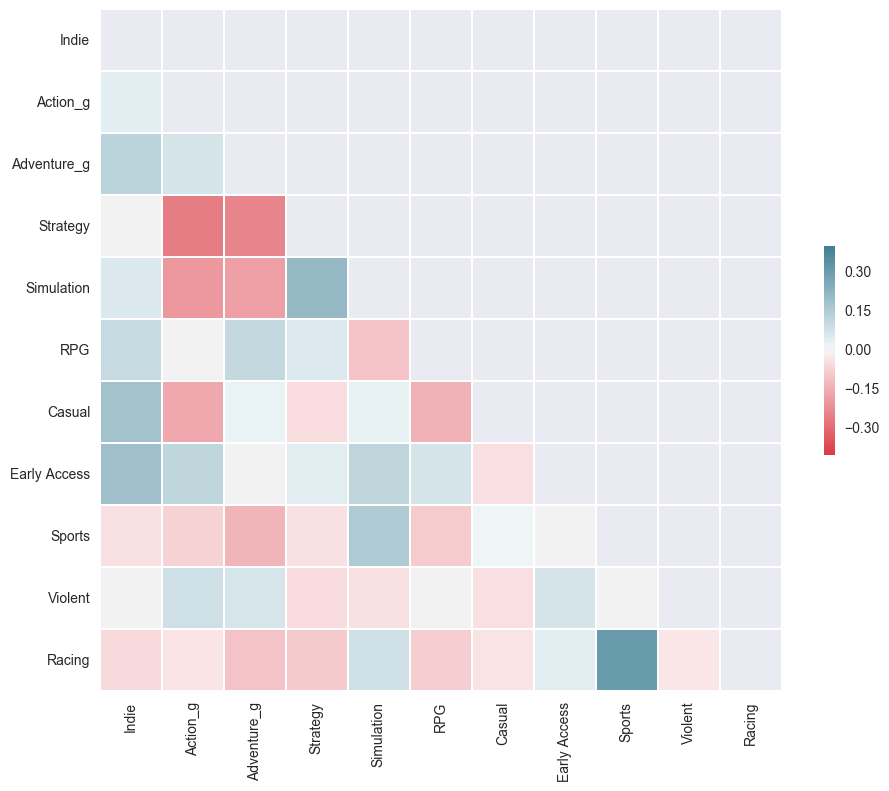

In [225]:
#generating a correlation plot
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .3}, ax=ax)
#none of the correlation nor the overlapping is very sigifnicant
sns.set_style("dark")

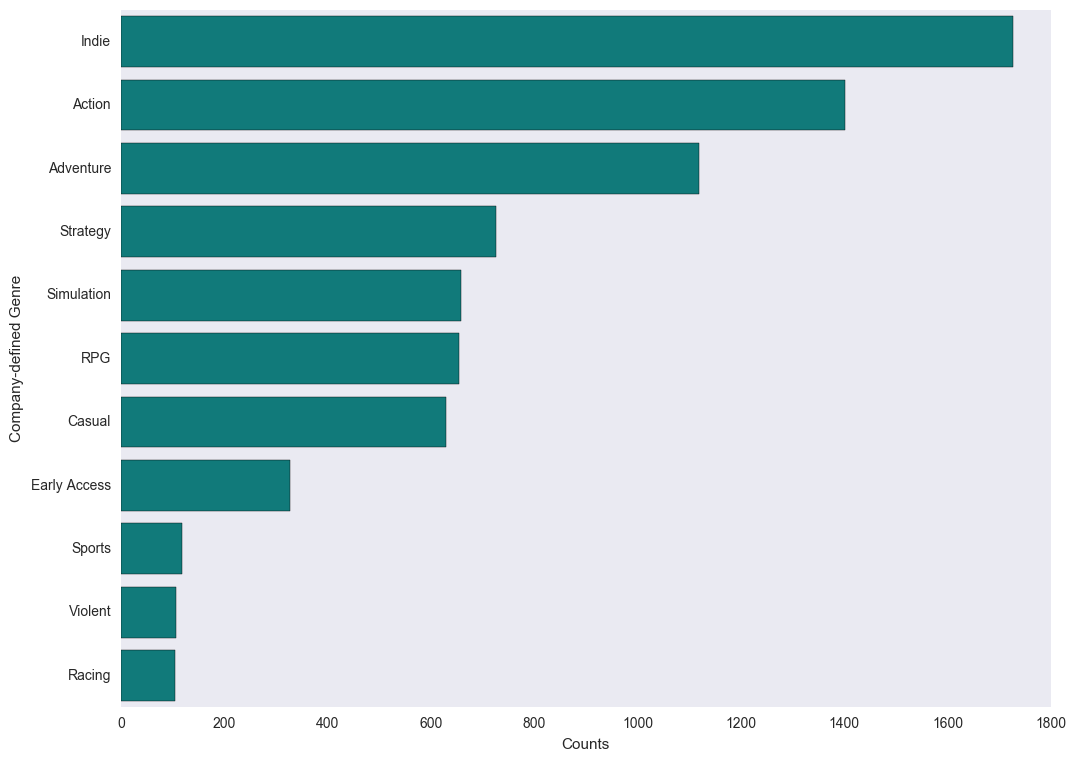

In [248]:
#matplot genre count
data = c[c['count']>100].sort_values(by = "count",ascending=False)
ax = sns.barplot(y="genre", x= "count", data=data,color="darkcyan",orient="h")
plt.ylabel('Company-defined Genre')
plt.xlabel('Counts')
sns.set_style("dark")

In [229]:
b

array(['Indie', 'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing'], dtype=object)

In [183]:
#import plotly settings
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import plotly
plotly.tools.set_credentials_file(username='jasonchiu0803', api_key='Jk1S0TST6AbhYxuAnYPD')

In [184]:
#interactive word counts for genre
import plotly.plotly as py
import plotly.graph_objs as go
subset_genre = b[b["count"]>100].sort_values(by = "count",ascending=True)
data = [go.Bar(
            x=subset_genre["count"],
            y=subset_genre["genre"],
            orientation = 'h')]
layout = go.Layout(
    title="Top Company Defined Genre",
    xaxis=dict(
        title="Counts"),
    yaxis=dict(
        title='Company Defined Genre'),autosize=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='horizontal-bar')

In [225]:
df_g = final_file[["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access",
                   "Sports","Violent","Racing","all_time","retention"]]

In [50]:
genre_name = ["Indie","Action_g","Adventure_g","Strategy","Simulation","RPG","Casual","Early Access","Sports",
            "Violent","Racing"]

In [228]:
def compiling_data(x):
    boxplot_data = pd.DataFrame(columns = ["present","all_time","genre_title"])
    for i in range(len(x)):
        y = genre_name[i]
        new = df_g[[y,"all_time"]]
        new.loc[:,"genre_title"] = y
        new.columns = ["present","all_time","genre_title"]
        boxplot_data = pd.concat([boxplot_data, new])
    return boxplot_data

In [229]:
boxplot_data = compiling_data(genre_name)

In [230]:
boxplot_data.head(2)

,present,all_time,genre_title
0,1.0,290.0,Indie
1,1.0,7.0,Indie


In [231]:
boxplot_data.shape

(33880, 3)

In [148]:
# Code for plotly plot
'''import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

Not_Action = go.Box(y = list(final_file['all_time'][final_file['Action_g']==0]),
                    boxpoints = False)
Action = go.Box(y = list(final_file['all_time'][final_file['Action_g']==1]),
                boxpoints = False)
data = [Not_Action, Action]
layout = go.Layout(yaxis=dict(
        range=[0, 4000]
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='axes-range-manual')'''

"import plotly.plotly as py\nimport plotly.graph_objs as go\n\nimport numpy as np\n\nNot_Action = go.Box(y = list(final_file['all_time'][final_file['Action_g']==0]),\n                    boxpoints = False)\nAction = go.Box(y = list(final_file['all_time'][final_file['Action_g']==1]),\n                boxpoints = False)\ndata = [Not_Action, Action]\nlayout = go.Layout(yaxis=dict(\n        range=[0, 4000]\n    )\n)\nfig = go.Figure(data=data, layout=layout)\npy.iplot(fig, filename='axes-range-manual')"

In [172]:
subbox = boxplot_data[boxplot_data["genre_title"].isin(["Indie","Casual","Action_g","RPG"])]

In [173]:
subbox.columns

Index([u'present', u'all_time', u'genre_title'], dtype='object')

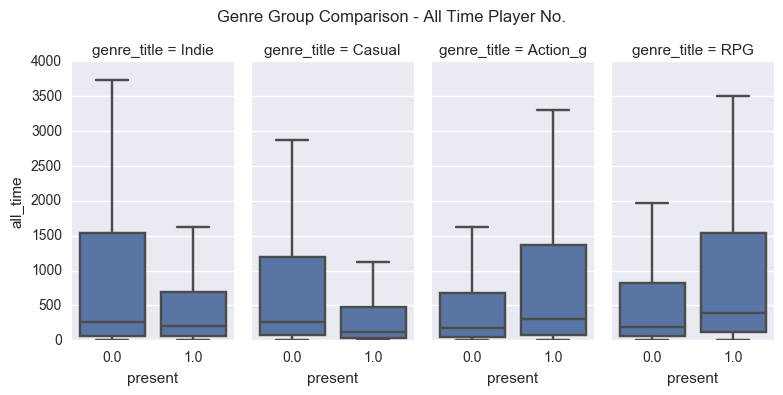

In [176]:
g = sns.FacetGrid(subbox, col="genre_title", size=4, aspect=.5, col_order = ['Indie','Casual','Action_g','RPG'])
g.map(sns.boxplot, "present", "all_time",showfliers=False);
axes = g.axes
axes[0,0].set_ylim(0,4000)
axes[0,1].set_ylim(0,4000)
axes[0,2].set_ylim(0,4000)
axes[0,3].set_ylim(0,4000)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Genre Group Comparison - All Time Player No.')

In [151]:
import scipy
def ttest_al(x):
    print final_file[["all_time",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["all_time"][final_file[x]==0],final_file["all_time"][final_file[x]==1])[1]

In [152]:
for i in range(len(genre_name)):
    ttest_al(genre_name[i])
    print "="*40

          all_time
Indie             
0      4715.494461
1      1391.255504
5.38566132419e-09
             all_time
Action_g             
0         2011.611674
1         3860.521413
0.00115548180445
                all_time
Adventure_g             
0            2810.376594
1            2926.664879
0.843639788181
             all_time
Strategy             
0         2885.995754
1         2744.229655
0.832028480989
               all_time
Simulation             
0           3025.391251
1           2215.469559
0.241926686447
        all_time
RPG             
0    2514.603669
1    4106.510703
0.0216245833685
           all_time
Casual             
0       3405.952060
1        696.499205
0.000114966030743
                 all_time
Early Access             
0             2831.118192
1             3034.315951
0.825518754952
           all_time
Sports             
0       2863.758778
1       2573.161017
0.844052935105
            all_time
Violent             
0        2799.914790
1        4346

In [232]:
def compiling_data_r(x):
    boxplot_data = pd.DataFrame(columns = ["present","retention","genre_title"])
    for i in range(len(x)):
        y = genre_name[i]
        new = df_g[[y,"retention"]]
        new.loc[:,"genre_title"] = y
        new.columns = ["present","retention","genre_title"]
        boxplot_data = pd.concat([boxplot_data, new])
    return boxplot_data

In [233]:
boxplot_data = compiling_data_r(genre_name)

In [235]:
import scipy
def ttest_r(x):
    print final_file[["retention",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["retention"][final_file[x]==0],final_file["retention"][final_file[x]==1])[1]

In [236]:
for i in range(len(genre_name)):
    ttest_r(genre_name[i])
    print "="*40

       retention
Indie           
0      14.008705
1       9.791254
7.77587662926e-17
          retention
Action_g           
0         13.079206
1          9.926841
4.52885949362e-10
             retention
Adventure_g           
0            12.991804
1             9.285578
1.37837298547e-12
          retention
Strategy           
0         11.003684
1         13.729400
4.51554274628e-06
            retention
Simulation           
0           10.875241
1           14.485208
4.3231099671e-09
     retention
RPG           
0    12.236653
1     9.451637
6.27521309453e-06
        retention
Casual           
0       11.907834
1       10.622242
0.040109969372
              retention
Early Access           
0             11.023535
1             16.897781
6.72576866624e-13
        retention
Sports           
0       11.403235
1       17.721264
1.50555234595e-06
         retention
Violent           
0        11.520554
1        15.179465
0.00853282214147
        retention
Racing           
0    

In [ ]:
subbox = boxplot_data[boxplot_data["genre_title"].isin(["Indie","Casual","Action_g","RPG"])]

In [ ]:
#return to do analysis on retention

In [153]:
#correlation between keywords
df_k = final_file[["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich",
                 "Open World","2D","Co-op","Sci-fi","Fantasy","Adventure_k","Puzzle","First-Person","Shooter",
                 "Difficult","Funny","Classic","Sandbox","Horror","Female Protagonist",
                 "FPS","Pixel Graphics","Comedy","Survival","Third Person","Anime","Platformer","Action_k","Turn-Based",
                "Exploration"]]

In [154]:
col_name_k = df_k.columns.values
new_k = pd.DataFrame(columns = col_name_k, index = col_name_k)

In [155]:
a_k = col_name_k
for i in range(len(a_k)):
    j = i
    new_k.loc[col_name_k[i],col_name_k[j]]=1
    j = i + 1 
    while j < len(a_k):
        new_k.loc[col_name_k[i],col_name_k[j]] = ORs(col_name_k[i],col_name_k[j],df_k)
        j = j + 1 

In [156]:
for i in range(len(a_k)):
    j = i
    new_k.loc[col_name_k[i],col_name_k[j]]=1
    j = i + 1 
    while j < len(a_k):
        new_k.loc[col_name_k[j],col_name_k[i]] = ORs(col_name_k[j],col_name_k[i],df_k)
        j = j + 1 

In [157]:
pd.set_option('display.max_columns', 100)

In [158]:
new_k

,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Fantasy,Adventure_k,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration
Singleplayer,1,3.36,6.17,8.56,5.87,5.56,3.3,3.18,5.02,5.34,11.25,2.19,4.18,3.67,3.79,3.93,4.72,4.13,2.19,2.69,2.59,1.6,4.24,3.01,22.21,1.27,1.91,10.98,3.44,5.58
Multiplayer,3.36,1,1.24,1.42,0.61,4.65,0.67,29.09,2.32,1.03,3.54,0.29,4.5,5.17,0.93,2.48,1.7,3.69,1.25,0.45,6.52,0.61,1.61,3.7,2.77,0.42,0.64,2.62,1.2,0.96
Great Soundtrack,6.17,1.24,1,4.6,6.42,1.65,3.65,1.33,2.29,2.38,2.88,1.97,1.32,1.47,3.35,2.38,2.88,1.19,1.29,2.6,0.82,2.95,2.01,0.75,3.03,3.05,3.42,2.35,1.26,2.8
Atmospheric,8.56,1.42,4.6,1,9.98,4.3,1.28,1.61,2.89,2.31,3.74,2.37,6.16,2.67,2.74,1.14,3.15,1.9,5.91,1.84,2.81,0.76,1.05,3.25,6.04,0.62,1.37,2.72,0.77,7.89
Story Rich,5.87,0.61,6.42,9.98,1,2.23,1.27,0.58,2.16,4.03,3.7,2.07,1.89,1.33,1.17,1.15,2.67,0.77,3.06,3.98,1.17,1.01,1.64,1.08,4.98,3.3,0.9,1.83,1.62,3.68
Open World,5.56,4.65,1.65,4.3,2.23,1,0.57,4.13,1.96,1.76,4.9,0.54,4.04,2.42,0.87,2.16,1.2,16.5,1.51,0.87,2.78,0.5,1.61,8.04,8.1,0.54,0.64,3.36,0.75,7.46
2D,3.3,0.67,3.65,1.28,1.27,0.57,1,1.19,1.18,1.78,1.05,2.17,0.03,0.74,4.54,2.26,0.87,1.21,0.91,1.64,0.04,20.93,2.31,1.1,0.09,1.82,11.79,1.15,1.16,1.7
Co-op,3.18,29.09,1.33,1.61,0.58,4.13,1.19,1,1.76,1.38,3.21,0.43,3.38,4.85,1.11,2.74,1.14,3.08,1.68,0.69,4.97,1.05,2.41,4.6,3.11,0.4,1.19,2.17,0.45,0.97
Sci-fi,5.02,2.32,2.29,2.89,2.16,1.96,1.18,1.76,1,0.41,2.91,0.6,3.57,4.53,1.14,0.84,2.89,1.65,1.63,1.23,4.02,0.94,1,2.07,1.44,0.68,1.01,1.59,1.84,2.21
Fantasy,5.34,1.03,2.38,2.31,4.03,1.76,1.78,1.38,0.41,1,3.49,1.33,0.47,0.11,1.44,1.43,2.05,0.95,0.34,2.65,0.18,1.42,1.98,0.48,3.28,2.17,1.38,2.46,6.35,1.85


In [159]:
df_k.corr()

,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Fantasy,Adventure_k,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration
Singleplayer,1.000000,0.254059,0.346358,0.371973,0.274918,0.268526,0.201652,0.194709,2.395582e-01,0.238101,0.301306,0.125601,0.210061,0.193152,0.197007,0.196298,0.209894,0.196446,0.118975,0.139738,0.134473,0.069300,1.837134e-01,0.149149,0.272662,0.035265,0.090381,0.228864,0.145988,0.181689
Multiplayer,0.254059,1.000000,0.044502,0.069952,-0.077511,0.290381,-0.063025,0.565346,1.474272e-01,0.005313,0.222766,-0.147013,0.261663,0.283595,-0.010496,0.150497,0.082625,0.215747,0.033487,-0.094100,0.294841,-0.060927,6.865723e-02,0.202574,0.153029,-0.096380,-0.054355,0.135605,0.022563,-0.004571
Great Soundtrack,0.346358,0.044502,1.000000,0.316761,0.351695,0.088748,0.242457,0.048430,1.439060e-01,0.147369,0.184011,0.112109,0.043213,0.061245,0.206883,0.141793,0.171678,0.025237,0.037265,0.148421,-0.025168,0.166728,1.028411e-01,-0.036080,0.166558,0.168132,0.185260,0.118410,0.029245,0.139556
Atmospheric,0.371973,0.069952,0.316761,1.000000,0.433142,0.272986,0.040465,0.081412,1.849326e-01,0.139419,0.230360,0.142460,0.318412,0.163864,0.168352,0.018629,0.186224,0.098535,0.296741,0.089399,0.158903,-0.033570,6.318255e-03,0.180616,0.277820,-0.054068,0.041679,0.139373,-0.028752,0.288903
Story Rich,0.274918,-0.077511,0.351695,0.433142,1.000000,0.130398,0.035194,-0.066193,1.189533e-01,0.230363,0.215761,0.107881,0.093568,0.038968,0.021057,0.017786,0.145788,-0.028954,0.169925,0.210343,0.019177,0.000973,6.254927e-02,0.009157,0.241886,0.170823,-0.011061,0.073044,0.055599,0.172950
Open World,0.268526,0.290381,0.088748,0.272986,0.130398,1.000000,-0.068252,0.246934,1.026876e-01,0.082656,0.269164,-0.067188,0.229098,0.134524,-0.016679,0.112846,0.023090,0.475994,0.055321,-0.015848,0.146656,-0.064086,6.033524e-02,0.331690,0.327907,-0.056859,-0.042987,0.164497,-0.027024,0.287891
2D,0.201652,-0.063025,0.242457,0.040465,0.035194,-0.068252,1.000000,0.024701,2.327742e-02,0.084294,0.006218,0.115536,-0.169092,-0.035943,0.249398,0.119764,-0.015982,0.023950,-0.010594,0.064054,-0.145776,0.492310,1.138025e-01,0.010946,-0.129063,0.076341,0.390304,0.015269,0.015651,0.060713
Co-op,0.194709,0.565346,0.048430,0.081412,-0.066193,0.246934,0.024701,1.000000,8.323841e-02,0.044343,0.187812,-0.084293,0.194323,0.261440,0.013114,0.152260,0.016296,0.170176,0.070517,-0.037839,0.248374,0.005122,1.197597e-01,0.230959,0.159676,-0.077614,0.019602,0.096499,-0.062960,-0.002753
Sci-fi,0.239558,0.147427,0.143906,0.184933,0.118953,0.102688,0.023277,0.083238,1.000000e+00,-0.084316,0.163809,-0.053855,0.198704,0.241617,0.015852,-0.019767,0.153842,0.064973,0.062616,0.023605,0.205002,-0.006570,-3.278136e-16,0.093240,0.042374,-0.035880,0.000600,0.051358,0.068637,0.092330
Fantasy,0.238101,0.005313,0.147369,0.139419,0.230363,0.082656,0.084294,0.044343,-8.431623e-02,1.000000,0.193111,0.036052,-0.070598,-0.132453,0.046542,0.044380,0.094920,-0.005137,-0.086817,0.131666,-0.105902,0.039890,8.474826e-02,-0.061202,0.161390,0.096768,0.035276,0.108925,0.260264,0.067210


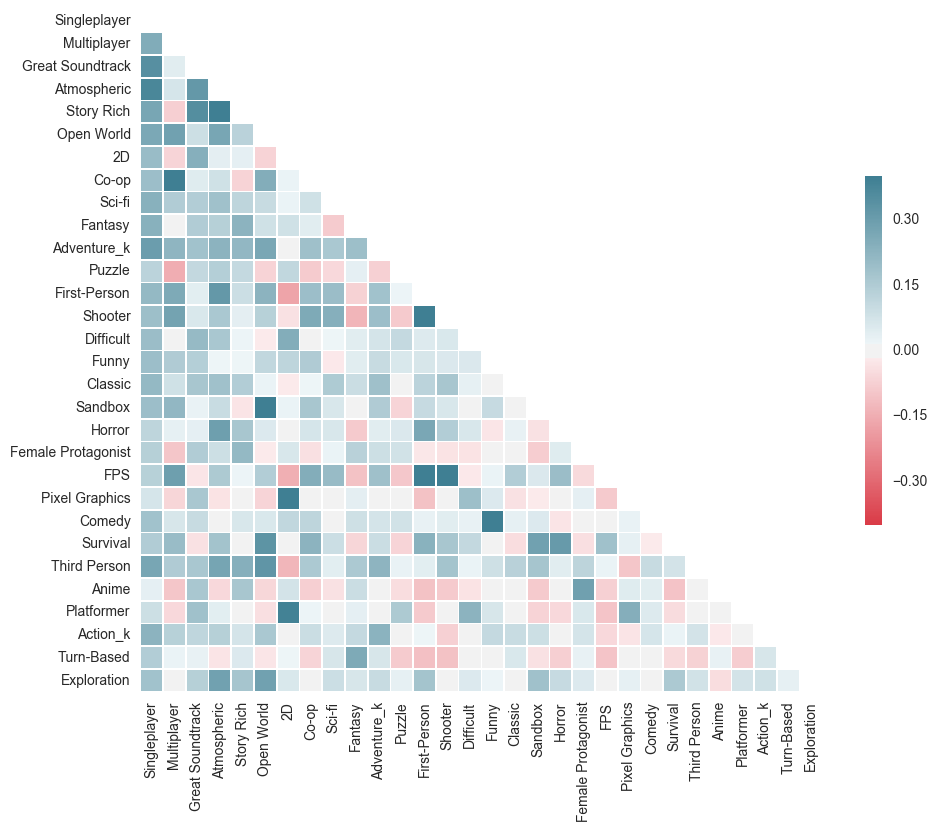

In [462]:
#generating a correlation plot
corr = df_k.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
#none of the correlation nor the overlapping is very sigifnicant
sns.set_style("whitegrid")

In [161]:
greater_k = 0
for i in range(len(a_k)):
    j = i + 1 
    while j < len(a_k):
        if new_k.loc[col_name_k[i],col_name_k[j]] > 1:
            greater_k = greater_k + 1
        j = j + 1 
greater_k_per = float(greater_k)/(float(sum(range(1,30)))-28)

In [162]:
greater_k_per

0.7936117936117936

In [163]:
(float(sum(range(1,29)))-28)

378.0

In [164]:
less_k = 0
for i in range(len(a_k)):
    j = i + 1 
    while j < len(a_k):
        if new_k.loc[col_name_k[i],col_name_k[j]] < 1:
            less_k = less_k + 1
        j = j + 1 
less_k_per = float(less_k)/(float(sum(range(1,30)))-28)

In [165]:
less_k_per

0.2727272727272727

top 28 keywords were included in the study:
73% were positively correlated with each other: meaning that the appearance of one keyword will increase the odds of the other odds: multiplayer & co-operation (all co-op games are multiplayer, but there are some competitive games), story-rich and atompheric, great soundtrack with atomspheric and story-rich => combining visual and music to create an immersive exeprience. open world and sand box
27% were negatively correlated with each other: meaning that the appearance of one keyword will decrease the odds of the other odds: puzzle and multiplayer, first-person, anime, playformer, and turn-based

In [166]:
test_list = ["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich","Open World","2D","Co-op",
             "Sci-fi","Adventure_k","Fantasy","Puzzle","First-Person","Shooter","Difficult","Funny","Classic",
             "Sandbox","Horror","Female Protagonist","FPS","Pixel Graphics","Comedy","Survival","Third Person",
             "Anime","Platformer","Action_k","Turn-Based","Exploration"]

In [167]:
len(test_list)

30

In [168]:
#insepecting all_time players/ 2 sample t-test/ p-value
import scipy
def ttest_al(x):
    print final_file[["all_time",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["all_time"][final_file[x]==0],final_file["all_time"][final_file[x]==1])[1]

In [169]:
for i in range(len(test_list)):
    ttest_al(test_list[i])
    print "="*50

                 all_time
Singleplayer             
0              801.317090
1             4598.210036
2.1183020195e-11
                all_time
Multiplayer             
0            1229.621260
1            6949.132723
5.42179481831e-20
                     all_time
Great Soundtrack             
0                 1935.442478
1                 5380.471341
7.34840578707e-08
                all_time
Atmospheric             
0            1503.175161
1            7082.110738
2.36438854925e-17
               all_time
Story Rich             
0           2470.698670
1           4719.904398
0.00287951028487
                all_time
Open World              
0            1376.599062
1           10102.436660
1.94708841959e-31
       all_time
2D             
0   3002.071596
1   2111.754352
0.240559073206
          all_time
Co-op             
0      1497.459160
1      9697.679764
2.13834300752e-27
           all_time
Sci-fi             
0       2382.146388
1       5602.314444
5.90980101582e-05
   

In [707]:
#insepecting retention relationship
def ttest_re(x):
    print final_file[["retention",x]].groupby(x).agg("mean")
    print scipy.stats.ttest_ind(final_file["retention"][final_file[x]==0],final_file["retention"][final_file[x]==1])[1]

In [15]:
#matplot word count
key[key["count"]>230].sort_values(by = "count",ascending=True).plot.barh(x="keywords")
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('User-defined keywords')

NameError: name 'key' is not defined

In [768]:
#interactive word counts for keywords
import plotly.plotly as py
import plotly.graph_objs as go
subset_key = key[key["count"]>230].sort_values(by="count")
data = [go.Bar(
            x=subset_key["count"],
            y=subset_key["keywords"],
            orientation = 'h')]
layout = go.Layout(
    title="User-defined Keywords",
    xaxis=dict(
        title="Counts"),
    yaxis=dict(
        title='User-defined Keywrods'),autosize=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='horizontal-bar')

In [177]:
test_list = ["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich","Open World","2D","Co-op",
             "Sci-fi","Adventure_k","Fantasy","Puzzle","First-Person","Shooter","Difficult","Funny","Classic",
             "Sandbox","Horror","Female Protagonist","FPS","Pixel Graphics","Comedy","Survival","Third Person",
             "Anime","Platformer","Action_k","Turn-Based","Exploration"]

In [178]:
df_key = final_file[["Singleplayer","Multiplayer","Great Soundtrack","Atmospheric","Story Rich","Open World","2D","Co-op",
             "Sci-fi","Adventure_k","Fantasy","Puzzle","First-Person","Shooter","Difficult","Funny","Classic",
             "Sandbox","Horror","Female Protagonist","FPS","Pixel Graphics","Comedy","Survival","Third Person",
             "Anime","Platformer","Action_k","Turn-Based","Exploration","all_time","retention"]]

In [179]:
def compiling_data_k(x):
    boxplot_data = pd.DataFrame(columns = ["present","all_time","keywords_title"])
    for i in range(len(x)):
        y = test_list[i]
        new = df_key[[y,"all_time"]]
        new.loc[:,"keywords_title"] = y
        new.columns = ["present","all_time","keywords_title"]
        boxplot_data = pd.concat([boxplot_data, new])
    return boxplot_data

In [180]:
boxplot_k = compiling_data_k(test_list)

In [186]:
positive = boxplot_k[boxplot_k["keywords_title"].isin(["Singleplayer","Atmospheric","Co-op","Sci-fi",
                                                       "Sandbox","FPS","Third Person","Exploration"])]

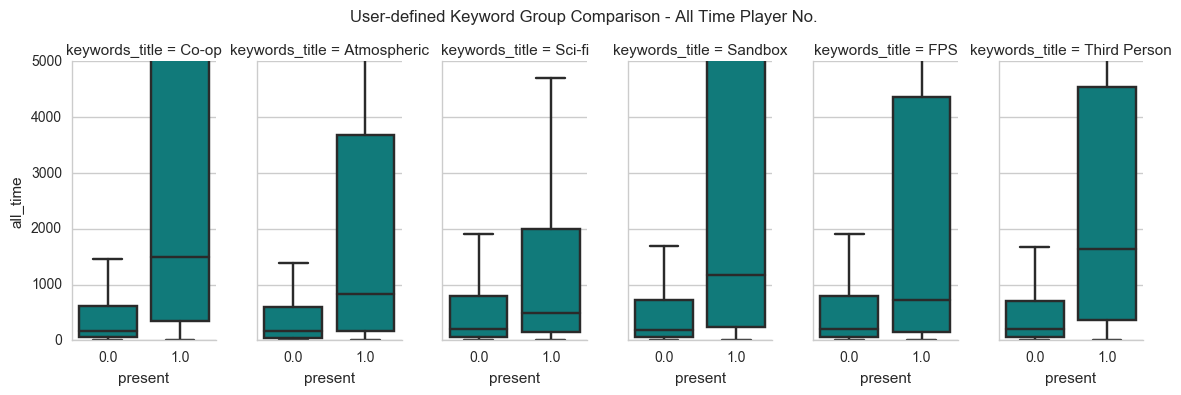

In [461]:
g = sns.FacetGrid(positive, col="keywords_title", size=4, aspect=.5, col_order = ['Co-op','Atmospheric',
                                                                                  'Sci-fi','Sandbox','FPS',
                                                                                  'Third Person'])
g.map(sns.boxplot, "present", "all_time",showfliers=False, color="darkcyan");
axes = g.axes
axes[0,0].set_ylim(0,5000)
axes[0,1].set_ylim(0,5000)
axes[0,2].set_ylim(0,5000)
axes[0,3].set_ylim(0,5000)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('User-defined Keyword Group Comparison - All Time Player No.')
sns.set_style("whitegrid")

For models, I will take into consideration: Singleplayer, atmospheric, co-op, sci-fi, sandbox, FPS,and 3rd person.

In [192]:
negative = boxplot_k[boxplot_k["keywords_title"].isin(["Puzzle","Anime"])]

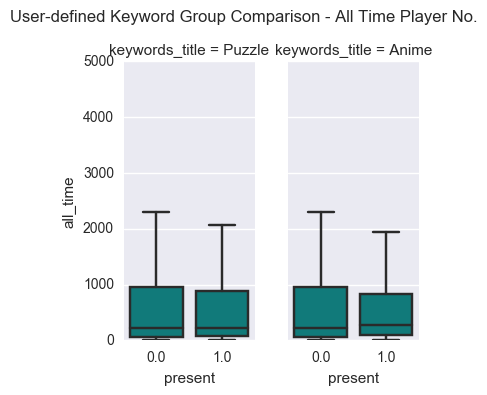

In [201]:
g = sns.FacetGrid(negative, col="keywords_title", size=4, aspect=.5, col_order = ['Puzzle','Anime'])
g.map(sns.boxplot, "present", "all_time",showfliers=False, color = "darkcyan");
axes = g.axes
axes[0,0].set_ylim(0,5000)
axes[0,1].set_ylim(0,5000)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('User-defined Keyword Group Comparison - All Time Player No.')

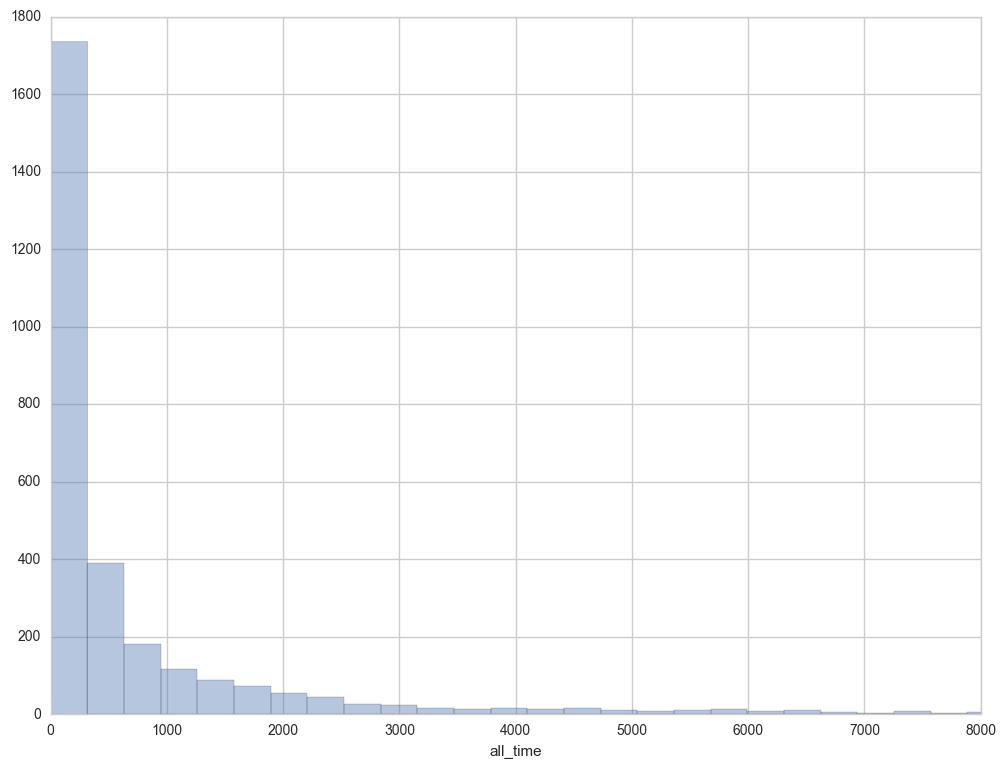

In [312]:
# all_time
import seaborn as sns
sns.distplot(final_file['all_time'], bins=1500, kde=False, rug=False);
plt.xlim(0, 8000)
sns.set_style("whitegrid")


In [241]:
final_file['all_time'].describe()

count      3080.000000
mean       2852.625487
std       15733.131851
min           1.000000
25%          62.000000
50%         228.500000
75%         949.750000
max      472962.000000
Name: all_time, dtype: float64

In [252]:
final_file[['mother_node','all_time']].sort_values(by = "all_time", ascending = False).head(10).reset_index()

,index,mother_node,all_time
0,870,Fallout 4,472962.0
1,1046,Grand Theft Auto V,364548.0
2,1689,No Man's Sky,212613.0
3,2232,Sid Meiers Civilization VI,162657.0
4,1385,Left 4 Dead 2,162163.0
5,2495,Terraria,159175.0
6,1784,PLAYERUNKNOWN'S BATTLEGROUNDS,144719.0
7,1082,H1Z1: King of the Kill,138218.0
8,3009,XCOM 2,133022.0
9,538,DARK SOULS III,129975.0


In [250]:
final_file[['mother_node','all_time']][final_file["all_time"]<100].shape

(1014, 2)

In [242]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'unique', 'Singleplayer', 'Multiplayer',
       'Great Soundtrack', 'Atmospheric', 'Story Rich', 'Open World', '2D',
       'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy', 'Puzzle',
       'First-Person', 'Shooter', 'Difficult', 'Funny', 'Classic',
       'Sandbox', 'Horror', 'Female Protagonist', 'FPS', 'Pixel Graphics',
       'Comedy', 'Survival', 'Third Person', 'Anime', 'Platformer',
       'Action_k', 'Turn-Based', 'Exploration', 'total_key', 'Indie',
       'Action_g', 'Adventure_g', 'Strategy', 'Simulation', 'RPG',
       'Casual', 'Early Access', 'Sports', 'Violent', 'Racing', 'retention'], dtype=object)

In [464]:
final_file[["YEAR","mother_node"]].groupby("YEAR").agg("count").reset_index().sort_values("YEAR",ascending = False)

,YEAR,mother_node
30,2017.0,467
29,2016.0,877
28,2015.0,501
27,2014.0,313
26,2013.0,194
25,2012.0,128
24,2011.0,89
23,2010.0,72
22,2009.0,67
21,2008.0,50


In [465]:
final_file[final_file["YEAR"]==1987.0]

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,DATE,unique,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Adventure_k,Fantasy,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement,retention
1863,Police Quest Collection,Police Quest Collection,494740,NaN,Single-player,NaN,NaN,"Adventure, Pixel Graphics, Classic, Detective,...",Adventure,0.0,0.0,4133,1.0,89.0,3.0,10835 days,1987.0,9.99,1987-09-07,"Detective, Pixel Graphics, Retro, Classic",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,5.0,0.2,1.123596


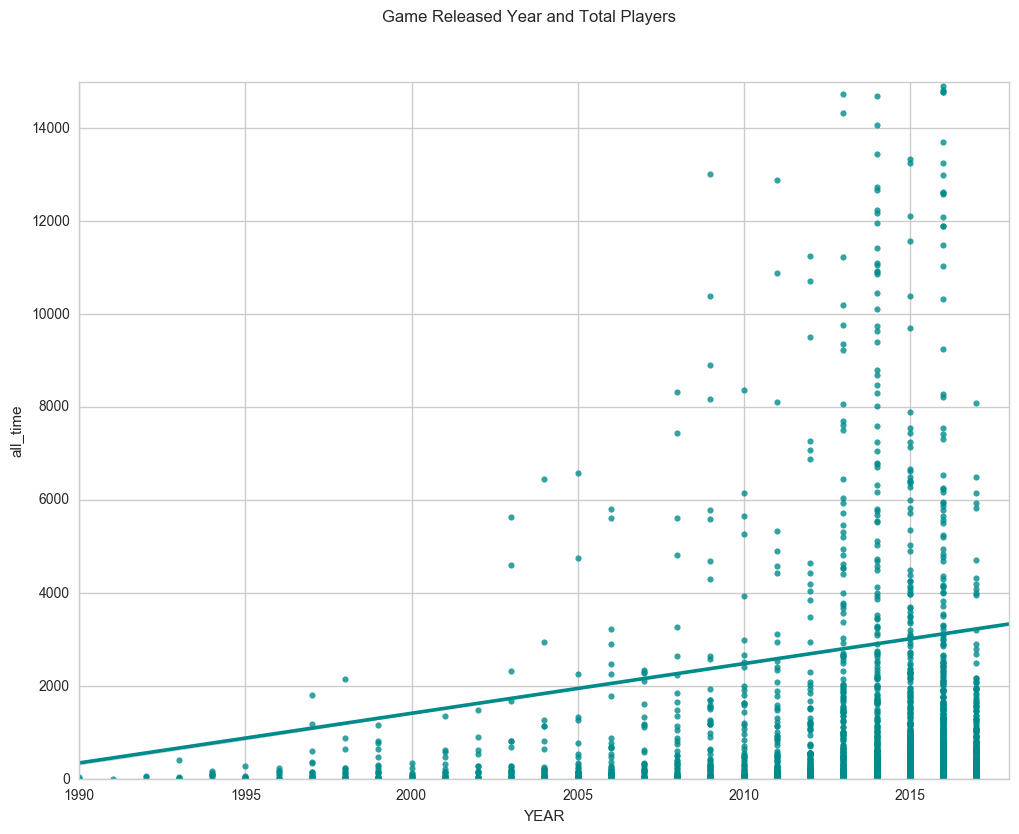

In [476]:
#plotting number of all_time users
ax = sns.regplot(x="YEAR", y="all_time", data=final_file, ci=0, color = "darkcyan")
plt.xlim(1990, 2018)
plt.ylim(0, 15000)
sns.plt.suptitle('Game Released Year and Total Players')
sns.set_style("whitegrid")

In [265]:
year_count = final_file[["YEAR","mother_node"]].groupby("YEAR").agg("count").reset_index()

In [266]:
year_count.columns

Index([u'YEAR', u'mother_node'], dtype='object')

In [288]:
pd.options.display.float_format = '{:f}'.format

In [298]:
year_count.YEAR.values

array([ 1987.,  1988.,  1989.,  1990.,  1991.,  1992.,  1993.,  1994.,
        1995.,  1996.,  1997.,  1998.,  1999.,  2000.,  2001.,  2002.,
        2003.,  2004.,  2005.,  2006.,  2007.,  2008.,  2009.,  2010.,
        2011.,  2012.,  2013.,  2014.,  2015.,  2016.,  2017.])

In [303]:
year_label = map(lambda x: str(x)[0:4], year_count.YEAR.values)

(0, 1000)

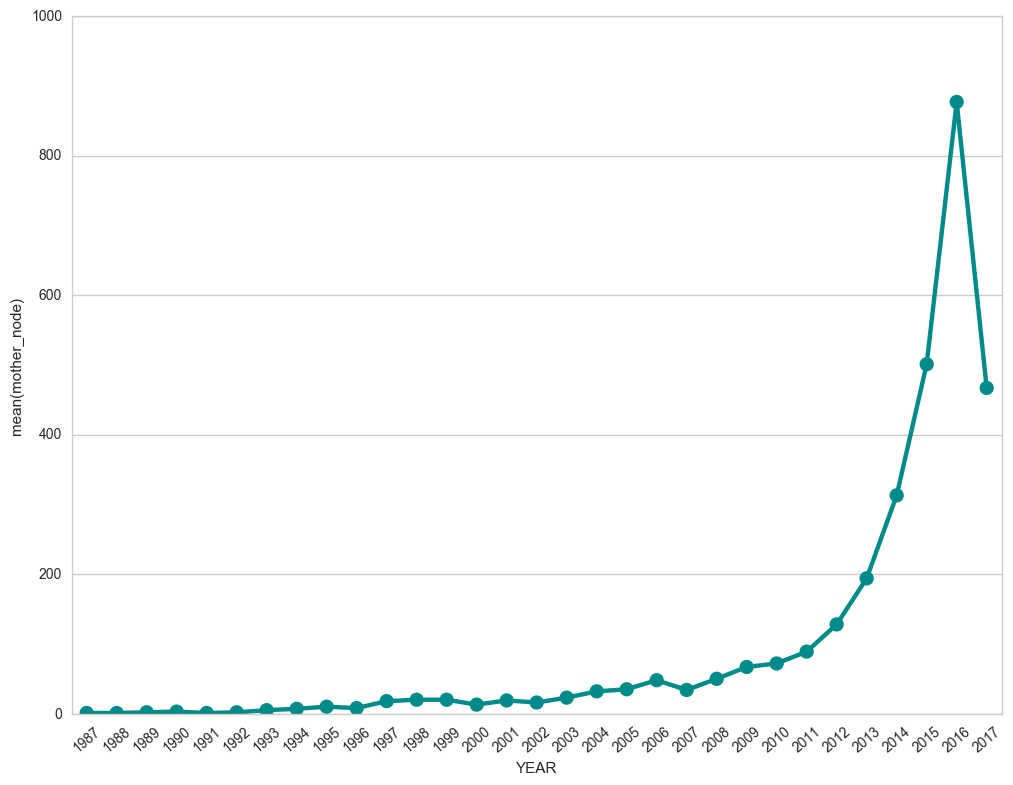

In [308]:
sns.set_style("whitegrid")
ax = sns.pointplot(x="YEAR", y="mother_node", data=year_count, color = "darkcyan")
ax.set_xticklabels(labels = year_label, rotation=40)
plt.ylim(0, 1000)

In [440]:
min(final_file["all_time"])

1.0

In [442]:
scipy.stats.ttest_ind(final_file["all_time"][final_file["dlc_av"]==0],final_file["dlc_av"][final_file[x]==1])

Ttest_indResult(statistic=7.2341849795195952, pvalue=5.5077908590848934e-13)

In [443]:
final_file[["all_time",'dlc_av']].groupby("dlc_av").agg("mean")

,all_time
dlc_av,
0.0,1370.574314
1.0,11380.919956


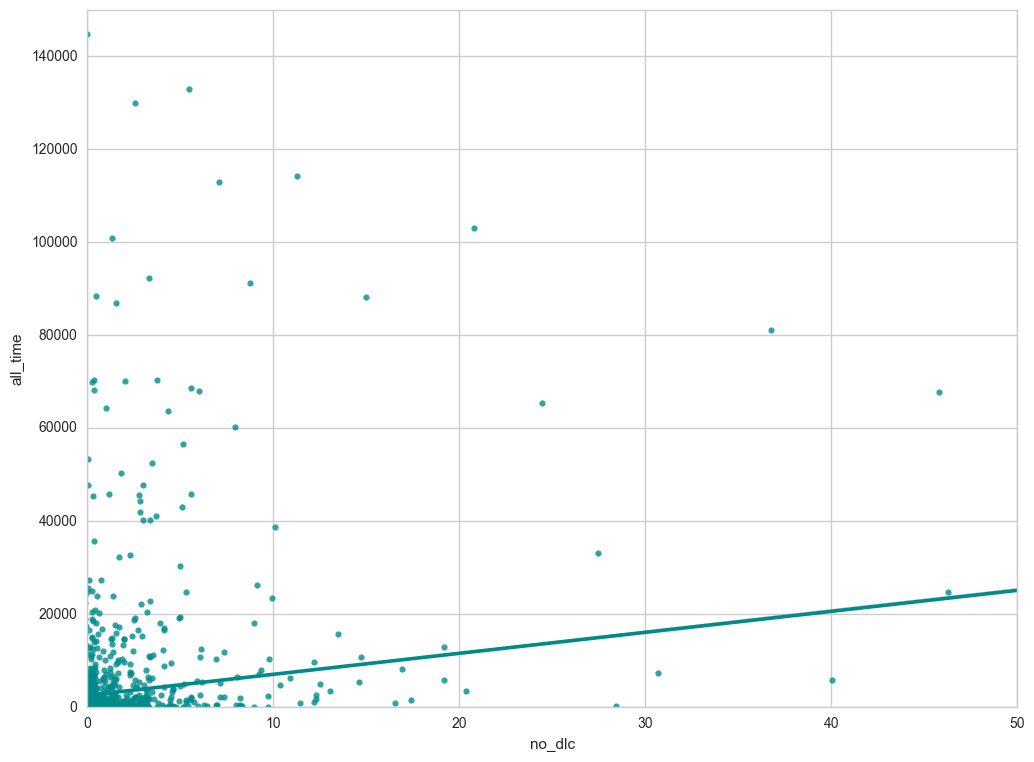

In [189]:
ax = sns.regplot(x="no_dlc", y="all_time", data=final_file,x_jitter=.5, color = "darkcyan",ci=0)
plt.ylim(0, 150000)
plt.xlim(0, 50)
sns.set_style("whitegrid")

In [455]:
final_file["no_dlc"].describe()

count    3080.000000
mean        0.601948
std         4.515211
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       211.000000
Name: no_dlc, dtype: float64

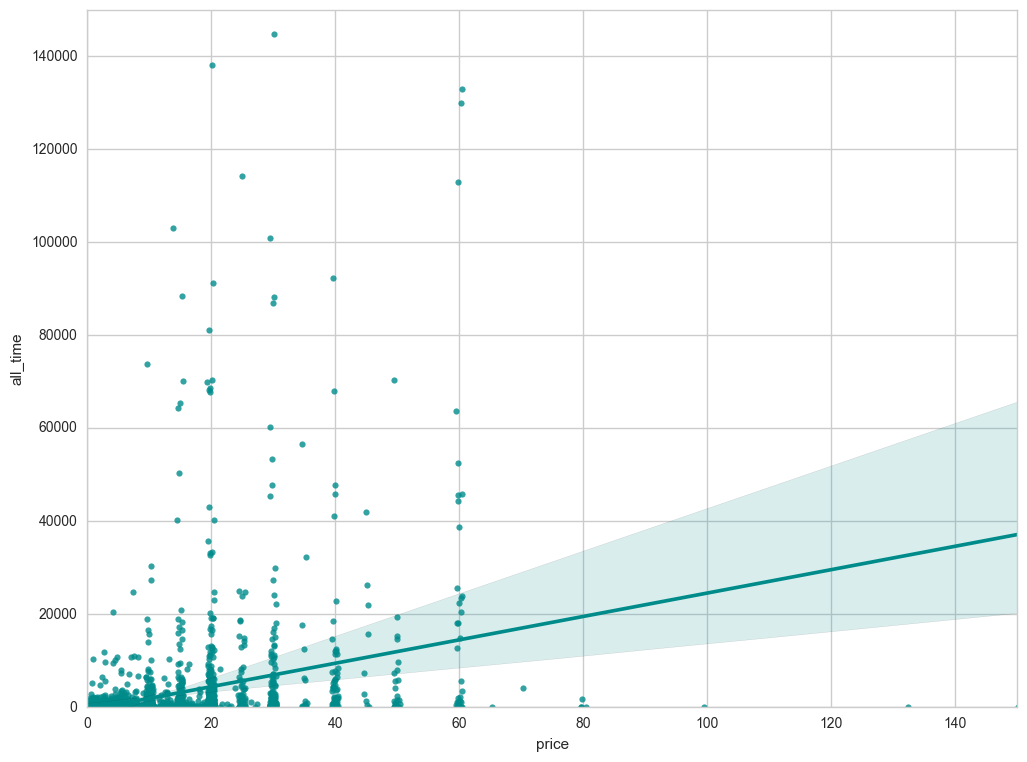

In [201]:
ax = sns.regplot(x="price", y="all_time", data=final_file,x_jitter=.5, color = "darkcyan")
plt.ylim(0, 150000)
plt.xlim(0, 150)
sns.set_style("whitegrid")

In [472]:
final_file[final_file["price"]>150]

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,dlc_av,rank_no,current,all_time,24_peak,time_diff,YEAR,price,DATE,unique,Indie,Action_g,Adventure_g,Strategy,Simulation,RPG,Casual,Early Access,Sports,Violent,Racing,Singleplayer,Multiplayer,Great Soundtrack,Atmospheric,Story Rich,Open World,2D,Co-op,Sci-fi,Adventure_k,Fantasy,Puzzle,First-Person,Shooter,Difficult,Funny,Classic,Sandbox,Horror,Female Protagonist,FPS,Pixel Graphics,Comedy,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement,retention
2854,VEGAS Pro 14 Edit Steam Edition,VEGAS Pro 14 Edit Steam Edition,528200,Very Positive,NaN,95.0,122.0,Video Production,Video Production,0.0,0.0,1205,24.0,88.0,36.0,219 days,2016.0,399.0,2016-09-30,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,27.272727


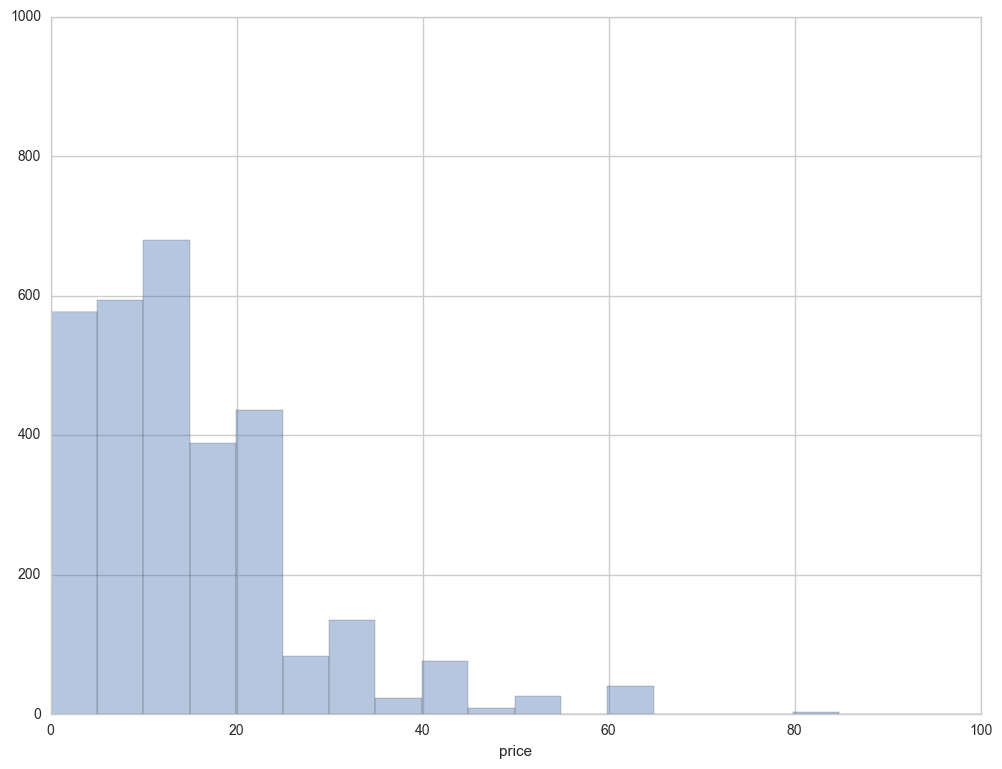

In [191]:
sns.distplot(final_file['price'], bins=80, kde=False, rug=False);
plt.ylim(0, 1000)
plt.xlim(0, 100)
sns.set_style("whitegrid")

In [481]:
final_file["price"].describe()

count    3080.000000
mean       13.681438
std        13.822477
min         0.000000
25%         4.990000
50%         9.990000
75%        19.990000
max       399.000000
Name: price, dtype: float64

In [206]:
final_file[final_file["price"]>200]

,mother_node,title_steam,app_id,user_rating,game_spcs,percent,reivew_users,keywords_list,genre_list,no_dlc,...,Survival,Third Person,Anime,Platformer,Action_k,Turn-Based,Exploration,total_key,agreement,retention
2854,VEGAS Pro 14 Edit Steam Edition,VEGAS Pro 14 Edit Steam Edition,528200,Very Positive,NaN,95.0,122.0,Video Production,Video Production,0.0,...,0,0,0,0,0,0,0,1.0,1.0,27.272727


In [190]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'DATE', 'unique', 'Indie', 'Action_g',
       'Adventure_g', 'Strategy', 'Simulation', 'RPG', 'Casual',
       'Early Access', 'Sports', 'Violent', 'Racing', 'Singleplayer',
       'Multiplayer', 'Great Soundtrack', 'Atmospheric', 'Story Rich',
       'Open World', '2D', 'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy',
       'Puzzle', 'First-Person', 'Shooter', 'Difficult', 'Funny',
       'Classic', 'Sandbox', 'Horror', 'Female Protagonist', 'FPS',
       'Pixel Graphics', 'Comedy', 'Survival', 'Third Person', 'Anime',
       'Platformer', 'Action_k', 'Turn-Based', 'Exploration', 'total_key',
       'agreement', 'retention'], dtype=object)

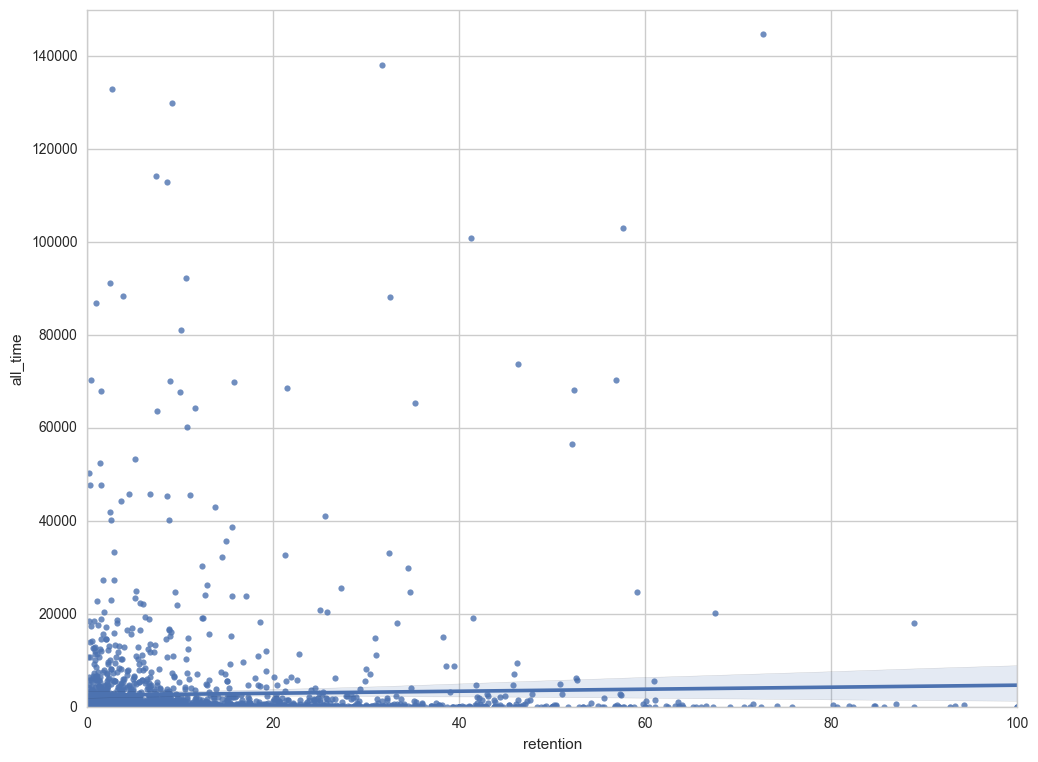

In [205]:
ax = sns.regplot(x="retention", y="all_time", data=final_file)
plt.ylim(0, 150000)
plt.xlim(0, 100)
sns.set_style("whitegrid")

In [194]:
max(final_file.retention)

100.0

In [257]:
con_df = final_file[["price","no_dlc","YEAR","agreement","total_key","retention","rank_no","all_time"]]

In [258]:
corr = con_df.corr()

In [259]:
corr

,price,no_dlc,YEAR,agreement,total_key,retention,rank_no,all_time
price,1.000000,0.115462,0.124666,-0.153029,0.191912,0.107031,-0.437294,0.221077
no_dlc,0.115462,1.000000,0.024032,-0.073652,0.088240,0.073473,-0.126758,0.129598
YEAR,0.124666,0.024032,1.000000,0.255428,-0.029508,-0.077938,-0.019430,0.031585
agreement,-0.153029,-0.073652,0.255428,1.000000,-0.709486,0.151187,0.335131,-0.130008
total_key,0.191912,0.088240,-0.029508,-0.709486,1.000000,-0.139202,-0.429449,0.212858
retention,0.107031,0.073473,-0.077938,0.151187,-0.139202,1.000000,-0.252645,0.019263
rank_no,-0.437294,-0.126758,-0.019430,0.335131,-0.429449,-0.252645,1.000000,-0.202897
all_time,0.221077,0.129598,0.031585,-0.130008,0.212858,0.019263,-0.202897,1.000000


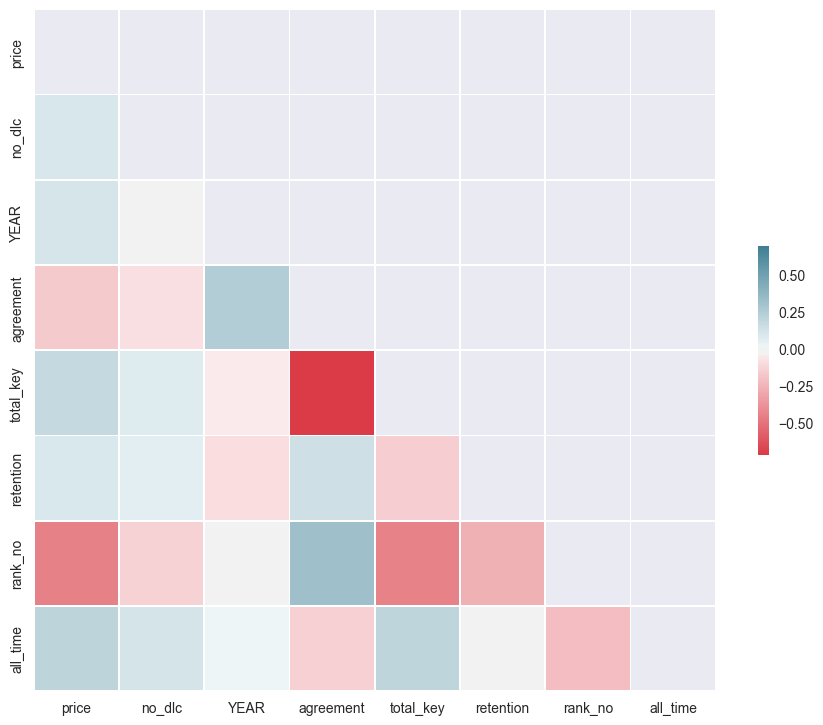

In [260]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .3}, ax=ax)
#none of the correlation nor the overlapping is very sigifnicant
sns.set_style("dark")

In [249]:
final_file.columns.values

array(['mother_node', 'title_steam', 'app_id', 'user_rating', 'game_spcs',
       'percent', 'reivew_users', 'keywords_list', 'genre_list', 'no_dlc',
       'dlc_av', 'rank_no', 'current', 'all_time', '24_peak', 'time_diff',
       'YEAR', 'price', 'DATE', 'unique', 'Indie', 'Action_g',
       'Adventure_g', 'Strategy', 'Simulation', 'RPG', 'Casual',
       'Early Access', 'Sports', 'Violent', 'Racing', 'Singleplayer',
       'Multiplayer', 'Great Soundtrack', 'Atmospheric', 'Story Rich',
       'Open World', '2D', 'Co-op', 'Sci-fi', 'Adventure_k', 'Fantasy',
       'Puzzle', 'First-Person', 'Shooter', 'Difficult', 'Funny',
       'Classic', 'Sandbox', 'Horror', 'Female Protagonist', 'FPS',
       'Pixel Graphics', 'Comedy', 'Survival', 'Third Person', 'Anime',
       'Platformer', 'Action_k', 'Turn-Based', 'Exploration', 'total_key',
       'agreement', 'retention'], dtype=object)